### Example Calibration with Discrepancy and Emulation - Bayarri function
In this example, we calibrate a modification of the function explored in Bayarri et al. (2007) titled "A framework for validation of computer models" in Technometrics incorporating discrepancy.

Calibrations involving discrepancy tend to be challenging, since there is often at best weak identifiability between input parameters and parameters in the discrepancy model. By "weak identifiability", we mean that there are  This is a difficult calibration problem there are many combinations of inputs that produce similar fits to the training data. In this example, we will also demonstrate simulation emulation using the **pyBASS** package available at https://github.com/lanl/pyBASS.

#%pip install ../.

In [2]:
import numpy as np
from impala import superCal as sc
import impala.superCal.post_process as pp
import pandas as pd
import matplotlib.pyplot as plt

We explore the following function, where one of the inputs is functional (X): f(X) = 1.5 + 3.5*exp(-1.7*X).

Suppose we observe three replicates of "real" data from y~N(f(X),0.3) where X ranges between 0.11 and 3.01 across a fixed grid of 10 values. Suppose we have a set of simulations in which (unbenownst to the person performing calibration) f(x) is incorrectly modeled as g(x) = M + 5*exp(-U*X) where M and U can range between 0.1 and 7. We generate these datasets as follows:

In [37]:
## Generate evaluations from g(X) across a grid of M and U
from itertools import product
def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], columns=dictionary.keys())
X = np.linspace(0.11, 3.01, 10)
dictionary = {'X': X, 
              'U': np.linspace(0.1,7,retstep = 0.1)[0], 
              'M': np.linspace(0.1,7,retstep = 0.1)[0]}
VALS = expand_grid(dictionary)
VALS['Y'] = VALS['M'] + 5*np.exp(-VALS['U']*VALS['X'])
DAT_sim_wide =  pd.DataFrame(VALS.pivot(index=['U','M'], columns='X', values='Y').reset_index())

## Generate "experimental" data
VALS_exp = expand_grid({'X': X, 'ind': np.linspace(1,3,3)})
VALS_exp['Y'] = 1.5 + 3.5*np.exp(-1.7*VALS_exp['X']) + np.random.normal(0,0.3,VALS_exp.shape[0])
DAT_exp_wide =  pd.DataFrame(VALS_exp.pivot(index=['ind'], columns='X', values='Y').reset_index())



Here, we plot the experimental data and simulations. 

Text(0.5, 1.0, 'Bayarri Function Data and Misspecified Simulation Outputs')

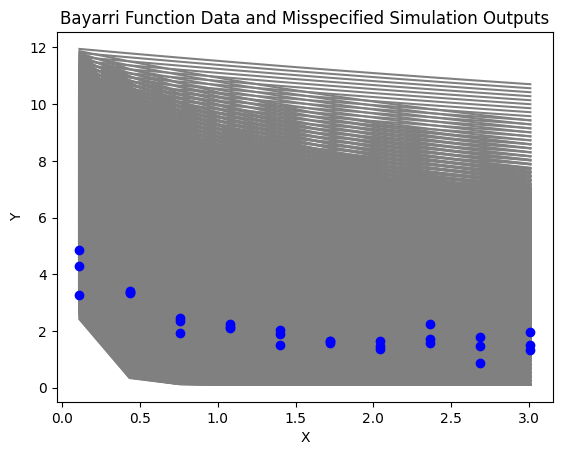

In [45]:
plt.plot(X,np.delete(np.array(DAT_sim_wide),np.s_[0:2], axis=1).T, color='grey', label='prior')
plt.scatter(X, np.array(DAT_exp_wide)[0,1:11], color='blue', label='obs', zorder = 10**6)
plt.scatter(X, np.array(DAT_exp_wide)[1,1:11], color='blue', label='obs', zorder = 10**6)
plt.scatter(X, np.array(DAT_exp_wide)[2,1:11], color='blue', label='obs', zorder = 10**6)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Bayarri Function Data and Misspecified Simulation Outputs')

Now, we suppose that the functional form of g(x) is not available and must be emulated. We will use the **bassPCA** method from the **pyBASS** package to do the emulation. 

In [46]:
import pyBASS as pb
from impala import superCal
import warnings

PARAMS = np.array(DAT_sim_wide)[:,0:2]
Y = np.delete(np.array(DAT_sim_wide),np.s_[0:2], axis=1)
warnings.simplefilter('ignore') #suppress divide by zero warnings that bassPCA deals with internally
mod = pb.bassPCA(xx=PARAMS, y=Y, ncores=1, percVar=99.9)
warnings.warn('default')

Starting bassPCA with 3 components, using 1 cores.
BASS MCMC Complete. Time: 4.895435 seconds.
BASS MCMC Complete. Time: 4.903753 seconds.
BASS MCMC Complete. Time: 4.950210 seconds.


An important step of this emulation to to evaluate how well it fits the simulation inputs. We can generate a set of diagnostic plots as follows. We want to see good correspondence between observed and posterior predictions and residuals that are generally small.

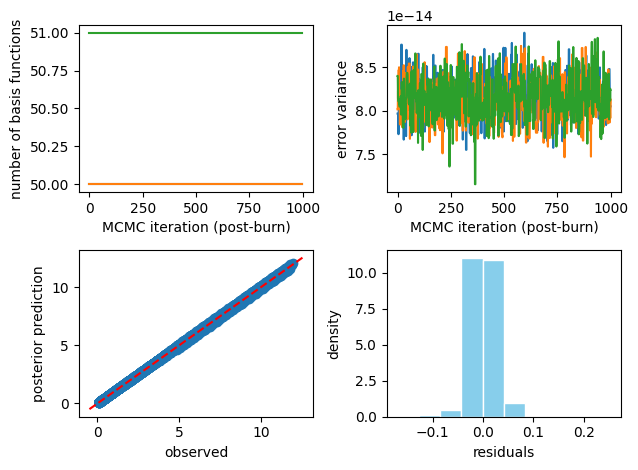

In [47]:
mod.plot()

Now, we define the IMPALA model structure. Since we used **bassPCA** to model this functional data, we use the following:

In [48]:
model_bayarri = superCal.ModelBassPca_func(mod, input_names = np.array(['U','M'])) 

Now we are ready to setup and run our calibration. We will perform two calibrations; one with and one without discrepancy. We model discrepancy as a linear combination of a vertical offset and a linear effect of X. We note that this discrepancy model is misspecified, because the true discrepancy is f(x) - g(x) = -1.5*exp(-1.7*X). 

In [49]:
bounds = {'U' : (0.0001,   7.), 'M'     : (0.0001,   7.)}
DMat = np.append(np.repeat(1,10).reshape(-1,1), (np.linspace(0.11, 3.01, 10)/3.01).reshape(-1,1),axis = 1)

### Fit without Discrepancy
setup = sc.CalibSetup(bounds) 
for ind in range(3):
    setup.addVecExperiments(yobs=np.delete(np.array(DAT_exp_wide),0,axis = 1)[ind,:].reshape(10,),     # observation vector
                        model=model_bayarri,   # model that predicts a vector
                        sd_est=np.array([0.01]),   # yobs error estimate (possibly a vector of estimates for different parts of yobs vector)
                        s2_df=np.array([10]),     # yobs error degrees of freedom (larger means more confidence in sd_est), same shape as sd_est
                        s2_ind=[0]*len(X)) # indicates that all values of X have the same noise variance

# Note: if you have multiple experiments, just call setup.addVecExperiments multiple times
setup.setTemperatureLadder(1.05**np.linspace(0,49,50), start_temper=500.) # temperature ladder, typically (1 + step)**np.arange(ntemps). start_temper indicates that tempering should start at iteration 500 
setup.setMCMC(nmcmc=15000,decor=20) # MCMC number of iterations, and how often to take a decorrelation step
out = sc.calibPool(setup) # pooled calibration (takes about 15 mins)

### Fit with Discrepancy
setup_disc = sc.CalibSetup(bounds) 
for ind in range(3):
    setup_disc.addVecExperiments(yobs=np.delete(np.array(DAT_exp_wide),0,axis = 1)[ind,:].reshape(10,),     # observation vector
                        model=model_bayarri,   # model that predicts a vector
                        sd_est=np.array([0.01]),   # yobs error estimate (possibly a vector of estimates for different parts of yobs vector)
                        s2_df=np.array([10]),     # yobs error degrees of freedom (larger means more confidence in sd_est), same shape as sd_est
                        s2_ind=[0]*len(X),# indicates that all values of X have the same noise variance
                        D = DMat, #discrepancy model basis
                        discrep_tau = 1/20) #standard error of discrepancy model basis coefficients

# Note: if you have multiple experiments, just call setup.addVecExperiments multiple times
setup_disc.setTemperatureLadder(1.05**np.linspace(0,49,50), start_temper=500.) # temperature ladder, typically (1 + step)**np.arange(ntemps). start_temper indicates that tempering should start at iteration 500 
setup_disc.setMCMC(nmcmc=15000,decor=20) # MCMC number of iterations, and how often to take a decorrelation step
out_disc = sc.calibPool(setup_disc) # pooled calibration (takes about 15 mins)

[2024-04-24 11:38:17 | 14999/14999 (100%) | WALL: 0:14:48 | ETA: 0:00:00 | 16.88it/s]
Calibration MCMC Complete. Time: 888.424858 seconds.
[2024-04-24 11:53:29 | 14999/14999 (100%) | WALL: 0:15:11 | ETA: 0:00:00 | 16.45it/s]
Calibration MCMC Complete. Time: 911.811442 seconds.


We can look at trace plots of the calibration parameters (theta) for the models with and without discrepancy.  We want these to look like they converge, and choose which MCMC iterations to use accordingly.

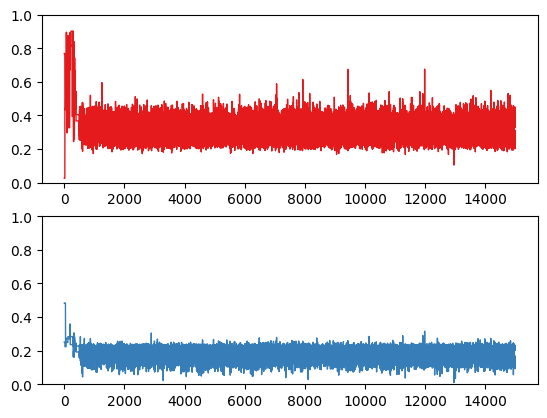

In [50]:
pp.parameter_trace_plot(out.theta[:, 0], ylim=[0, 1])
pp.parameter_trace_plot(out_disc.theta[:, 0], ylim=[0, 1])

We disregard the first 5000 iterations and use every other iteration after that, which leaves us with 5000 iterations from our original 15000.  Here is the pairs plot of the calibration parameters' posterior (theta).

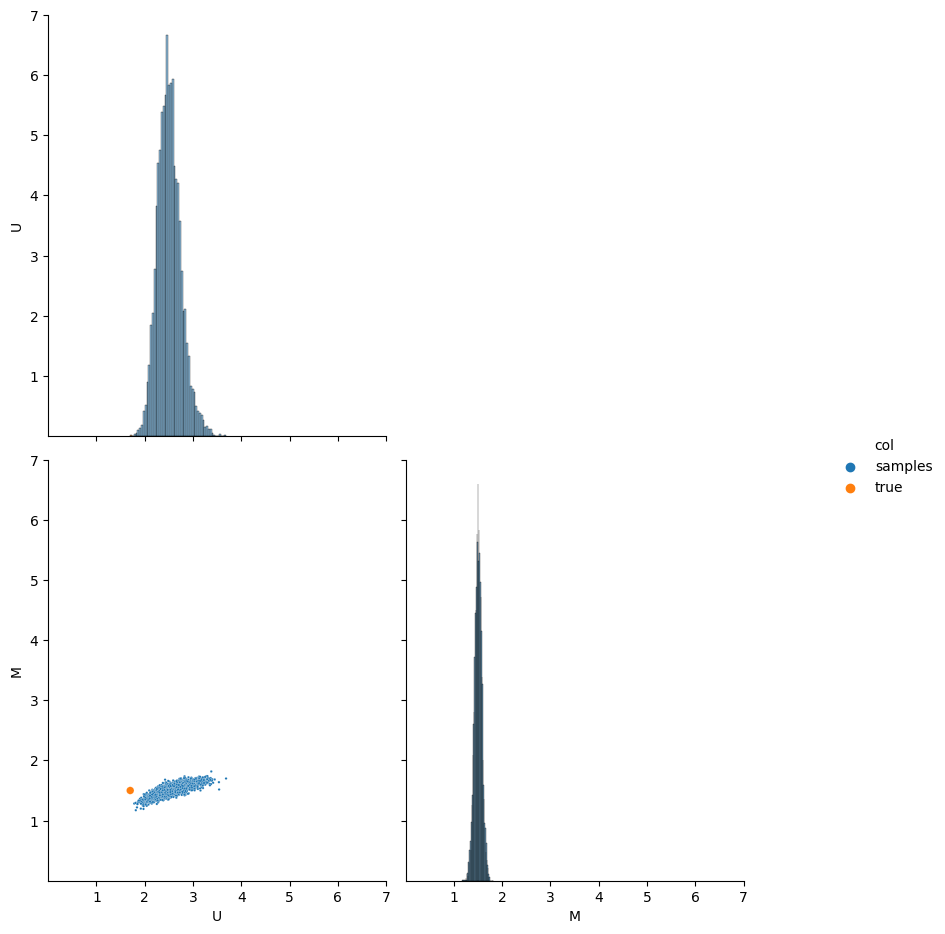

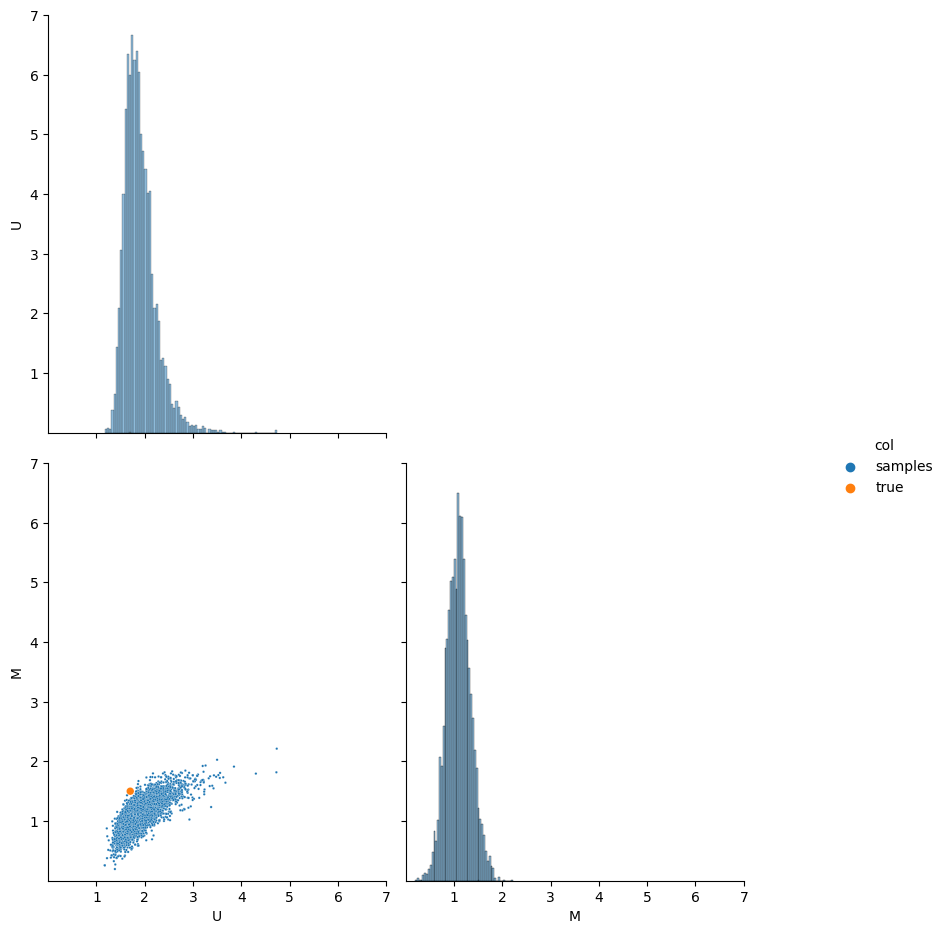

In [51]:
mcmc_use = np.arange(5000, 15000, 2) # burn and thin index

mat_theta_xxtrue = np.vstack((out.theta[mcmc_use, 0], sc.normalize(np.array([1.7,1.5]), setup.bounds_mat)))
col = ['samples']*len(mcmc_use) + ['true'] # color
s = [3]*len(mcmc_use) + [30] # size
pp.pairs(setup, mat_theta_xxtrue, col, s)

mat_theta_xxtrue = np.vstack((out_disc.theta[mcmc_use, 0], sc.normalize(np.array([1.7,1.5]), setup_disc.bounds_mat)))
col = ['samples']*len(mcmc_use) + ['true'] # color
s = [3]*len(mcmc_use) + [30] # size
pp.pairs(setup_disc
         , mat_theta_xxtrue, col, s)

We also give the trace plot of the error variance (with the true values).

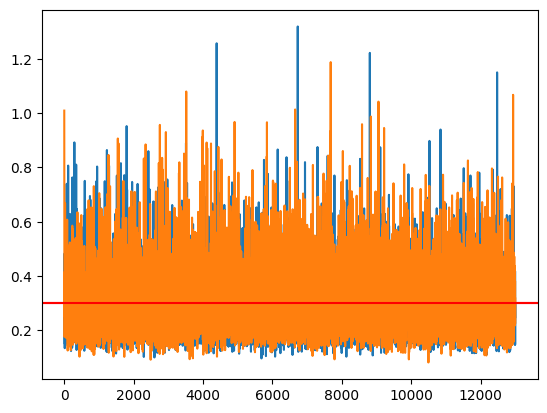

In [52]:
plt.plot(out.s2[0][2000:,0])
plt.axhline(0.3, color='r')

plt.plot(out_disc.s2[0][2000:,0])
plt.axhline(0.3, color='r')

Let's produce our calibrated posterior predictions (with and without the observation error) with the observational data. Since the discrepancy model is misspecified, we still see some deviation from the predictions and the observed values, but the coverage of the noiseless predictions (light blue) is better for the model with discrepancy, which adds additional uncertainty into the estimation. 

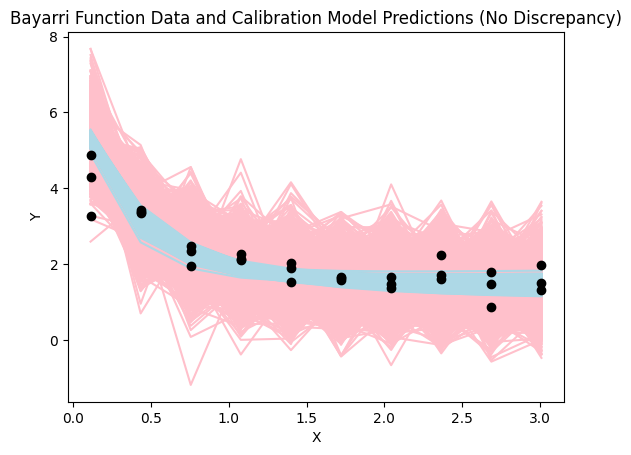

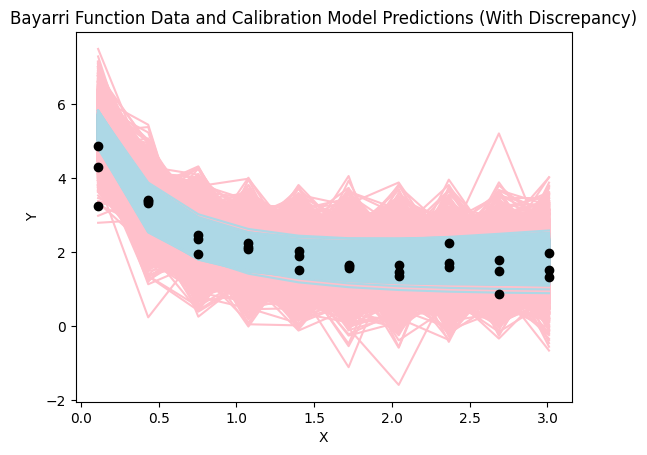

In [88]:
mat = np.array(list(out.theta_native.values())).T[mcmc_use]
pred = setup.models[0].eval(dict(pd.DataFrame(mat, columns = np.array(pd.DataFrame(bounds.keys())).flatten())))
pred_s2 = np.random.normal(size=(len(mcmc_use), len(X))) * np.sqrt(out.s2[0][mcmc_use, 0])
plt.plot(np.repeat(X.reshape(1,-1), pred.shape[0],axis=0).T, (pred + pred_s2).T, color='pink') # posterior predictions including noise
plt.plot(np.repeat(X.reshape(1,-1), pred.shape[0],axis=0).T, pred.T, color='lightblue') # posterior predictions of noiseless function
plt.scatter(X, np.array(DAT_exp_wide)[0,1:11], color='black', label='obs', zorder = 10**6)
plt.scatter(X, np.array(DAT_exp_wide)[1,1:11], color='black', label='obs', zorder = 10**6)
plt.scatter(X, np.array(DAT_exp_wide)[2,1:11], color='black', label='obs', zorder = 10**6)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Bayarri Function Data and Calibration Model Predictions (No Discrepancy)')
plt.show()

mat_disc = np.array(list(out_disc.theta_native.values())).T[mcmc_use]
disc_overall = np.append(out_disc.discrep_vars[0][mcmc_use,0,:]@ DMat.T, out_disc.discrep_vars[1][mcmc_use,0,:]@ DMat.T, axis = 1)
disc_overall = np.append(disc_overall, out_disc.discrep_vars[2][mcmc_use,0,:]@ DMat.T, axis=1)
disc_avg = (disc_overall[:,0:10]+disc_overall[:,10:20]+disc_overall[:,20:30])/3
pred_disc = setup.models[0].eval(dict(pd.DataFrame(mat, columns = np.array(pd.DataFrame(bounds.keys())).flatten()))) + disc_avg
pred_s2_disc = np.random.normal(size=(len(mcmc_use), len(X))) * np.sqrt(out_disc.s2[0][mcmc_use, 0])
plt.plot(np.repeat(X.reshape(1,-1), pred_disc.shape[0],axis=0).T,(pred_disc + pred_s2_disc).T, color='pink') # posterior predictions including noise
plt.plot(np.repeat(X.reshape(1,-1), pred_disc.shape[0],axis=0).T, pred_disc.T, color='lightblue') # posterior predictions of noiseless function
plt.scatter(X, np.array(DAT_exp_wide)[0,1:11], color='black', label='obs', zorder = 10**6)
plt.scatter(X, np.array(DAT_exp_wide)[1,1:11], color='black', label='obs', zorder = 10**6)
plt.scatter(X, np.array(DAT_exp_wide)[2,1:11], color='black', label='obs', zorder = 10**6)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Bayarri Function Data and Calibration Model Predictions (With Discrepancy)')
plt.show()

Now, suppose we want to obtain a single set of parameter estimates that best agree with out observed data. Several reasonable approaches exist, but here we identify the posterior draw of theta with the smallest squared prediction error.

In [89]:
pred_sse = np.sum((pred-np.repeat(setup.ys[0].reshape(1,-1), len(mcmc_use), axis = 0))**2,axis=1)
theta_minsse = mat[np.where(pred_sse == pred_sse.min())[0][0],:]

pred_sse_disc = np.sum((pred_disc-np.repeat(setup_disc.ys[0].reshape(1,-1), len(mcmc_use), axis = 0))**2,axis=1)
theta_minsse_disc = mat_disc[np.where(pred_sse_disc == pred_sse_disc.min())[0][0],:]

Now, we compare the two models in terms of their "best" predictions:

Text(0.5, 1.0, 'Bayarri Function Data and Calibration Model Predictions (Best Draws)')

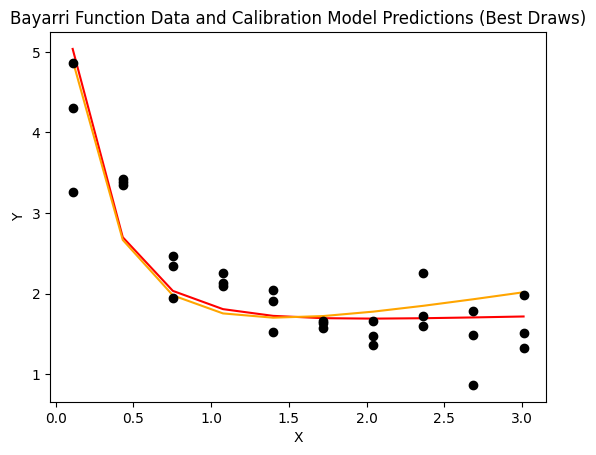

In [91]:
plt.plot(X,pred[np.where(pred_sse == pred_sse.min())[0][0],:], color='red') # observations
plt.plot(X,pred_disc[np.where(pred_sse_disc == pred_sse_disc.min())[0][0],:], color='orange') # observations
plt.scatter(X, np.array(DAT_exp_wide)[0,1:11], color='black', label='obs', zorder = 10**6)
plt.scatter(X, np.array(DAT_exp_wide)[1,1:11], color='black', label='obs', zorder = 10**6)
plt.scatter(X, np.array(DAT_exp_wide)[2,1:11], color='black', label='obs', zorder = 10**6)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Bayarri Function Data and Calibration Model Predictions (Best Draws)')

Finally, let's take a look at discrepancy. Below, we generate trace plots for the discrepancy basis coefficients and posterior draws for the overall discrepancy as a function of X and experiment. Since the discrepancy function was misspecified (assumed linear in X instead of exponential in X), it is not surprising that the estimated discrepancies do not cover the truth, particularly for small X values. 

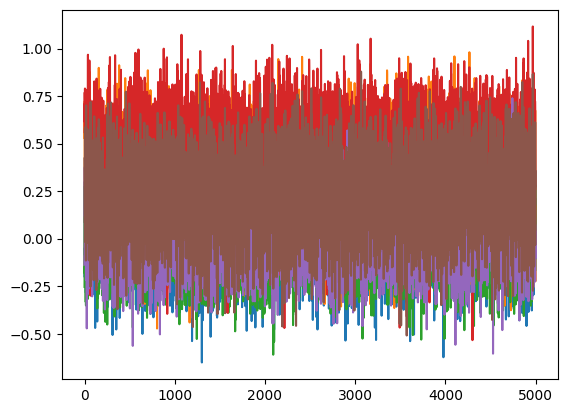

(5000, 30)


Text(0.5, 1.0, 'Bayarri Function Data and Calibration Model Predictions (Best Draws)')

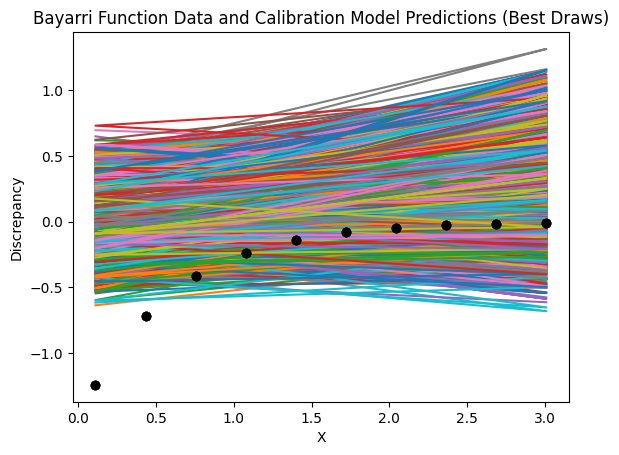

In [78]:
disc_v = np.append(out_disc.discrep_vars[0][mcmc_use,0,:], out_disc.discrep_vars[1][mcmc_use,0,:], axis = 1)
disc_v = np.append(disc_v, out_disc.discrep_vars[2][mcmc_use,0,:], axis=1)
plt.plot(disc_v)
plt.show()

disc_overall = np.append(out_disc.discrep_vars[0][mcmc_use,0,:]@ DMat.T, out_disc.discrep_vars[1][mcmc_use,0,:]@ DMat.T, axis = 1)
disc_overall = np.append(disc_overall, out_disc.discrep_vars[2][mcmc_use,0,:]@ DMat.T, axis=1)

plt.plot(np.repeat(X_long.reshape(1,-1),disc_overall.shape[0],axis=0).T, disc_overall.T, label='obs', zorder = 10**6)
plt.scatter(X_long, (1.5 + 3.5*np.exp(-1.7*X_long)) - 1.5 - 5*np.exp(-1.7*X_long), color='black', label='obs', zorder = 10**6)

plt.xlabel('X')
plt.ylabel('Discrepancy')
plt.title('Bayarri Function Data and Calibration Model Predictions (Best Draws)')